# Base BERT implementation

1. Import dependencies

In [1]:
import random
import time

import numpy as np
import torch

from transformers import (
    AutoTokenizer,
    DataCollatorForTokenClassification,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)

from src.util.torch_device import resolve_torch_device
from src.data.span_detection_ds import ManipulationDetectionDataset
from src.visualization.plot import plot_loss, plot_model_progress
from src.definitions import MODELS_FOLDER, RAW_DATA_FOLDER, REPORTS_FOLDER
from src.visualization.ner import visualize_as_markdown_and_save
from src.visualization.reporting import EvaluatingReport
from src.model.span_detection_metrics import compute_metrics

2. Prepare Env

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

model_checkpoint = "bert-base-multilingual-cased"

epoch_time = int(time.time())

3. Load dataset

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

dataset_blueprint = ManipulationDetectionDataset(tokenizer, random_seed)

dataset = dataset_blueprint.read(RAW_DATA_FOLDER / "span-detection.parquet")

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

3. Prepare model

In [4]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(dataset_blueprint.label2id),
    id2label=dataset_blueprint.id2label,
    label2id=dataset_blueprint.label2id,
).to(device)

data_collator = DataCollatorForTokenClassification(tokenizer)

training_args = TrainingArguments(
    output_dir=MODELS_FOLDER / "manipulation-detector-bert-ner-checkpoint",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    seed=random_seed,
    logging_steps=100
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics(dataset_blueprint),
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


4. Train model

In [5]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.453400,0.435579,0.036846,0.072427,0.048843,0.775397
2,0.411300,0.424182,0.056911,0.088945,0.069410,0.787933
3,0.355400,0.455201,0.059284,0.067344,0.063058,0.784261
4,0.319300,0.451387,0.063773,0.091487,0.075157,0.791468


/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/.venv/lib/python3.11/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: MANIPULATION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/.venv/lib/python3.11/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: MANIPULATION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/.venv/lib/python3.11/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: MANIPULATION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/.venv/lib/python3.11/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: MANIPULATION seems not to be NE tag.
  warnings.warn('{} seems no

TrainOutput(global_step=860, training_loss=0.38996984792310135, metrics={'train_runtime': 1169.6972, 'train_samples_per_second': 11.76, 'train_steps_per_second': 0.735, 'total_flos': 3290263560831324.0, 'train_loss': 0.38996984792310135, 'epoch': 4.0})

In [6]:
evaluation_feedback = trainer.evaluate()

/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/.venv/lib/python3.11/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: MANIPULATION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [7]:
report_file = REPORTS_FOLDER / "span-detection" / "train-report.csv"

report = EvaluatingReport(report_file)

report.write_to_report(evaluation_feedback, epoch_time)

full_report = report.read_report()

full_report.tail(1)

,timestamp,eval_loss,eval_precision,eval_recall,eval_f1,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
2,1738438948,0.424182,0.056911,0.088945,0.06941,0.787933,8.6378,44.34,2.778,4.0


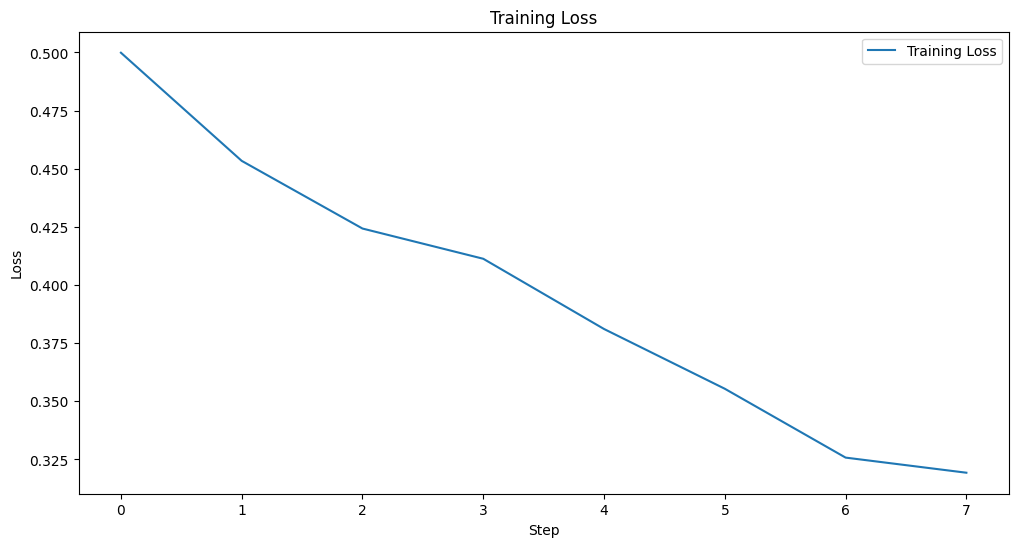

In [8]:
plot_loss(trainer)

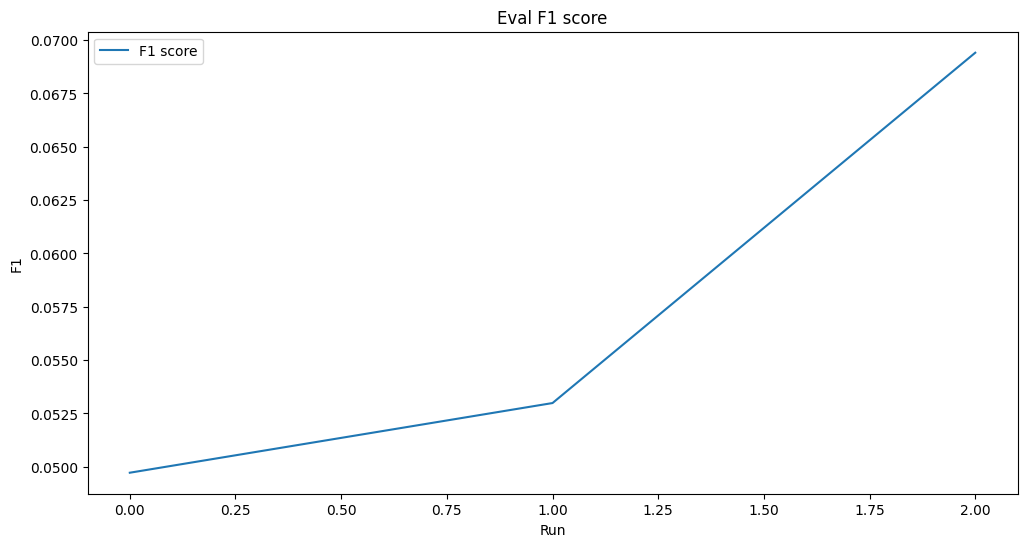

In [9]:
plot_model_progress(full_report)

5. Save weights

In [10]:
trainer.save_model(MODELS_FOLDER / "manipulation-detector-bert-ner-model")
tokenizer.save_pretrained(MODELS_FOLDER / "manipulation-detector-bert-ner-model")

('/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-detector-bert-ner-model/tokenizer_config.json',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-detector-bert-ner-model/special_tokens_map.json',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-detector-bert-ner-model/vocab.txt',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-detector-bert-ner-model/added_tokens.json',
 '/Users/alexandermelashchenko/Workspace/unlp-2025-manipulation-detector/models/manipulation-detector-bert-ner-model/tokenizer.json')

6. Test

In [11]:
model = AutoModelForTokenClassification.from_pretrained(
    MODELS_FOLDER / "manipulation-detector-bert-ner-model"
)
tokenizer = AutoTokenizer.from_pretrained(
    MODELS_FOLDER / "manipulation-detector-bert-ner-model"
)

In [12]:
test_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

test_result = test_pipeline(dataset["test"]["content"])

Device set to use mps:0


In [13]:
visualize_as_markdown_and_save(
    dataset["test"],
    test_result,
    tokenizer,
    REPORTS_FOLDER / "span-detection" / "test-visualization" / f"test-{epoch_time}.md",
)

Dataset({
    features: ['id', 'content', 'lang', 'manipulative', 'techniques', 'trigger_words', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 383
})


In [14]:
# test_result[1]

In [15]:
# test = dataset["test"][1]

# print(test["content"][0:133])
# print(test["content"][135:250])
# print()
# print(test["content"])
# print(test["labels"])

In [16]:
# dataset["train"][1]

In [17]:
# content = dataset["train"][1]["content"]
# trigger_words = dataset["train"][1]["trigger_words"]

# for it in trigger_words:
#     print(content[it[0]: it[1]])

In [18]:
# labels = dataset["train"][1]['labels']
# input_ids = dataset["train"][1]["input_ids"]

# sub_str = []

# for i in range(len(labels)):
#     if labels[i] == 1:
#         sub_str.append(input_ids[i])

# tokenizer.decode(sub_str)

In [19]:
# tokenizer.convert_ids_to_tokens(dataset["test"][1]["input_ids"])

In [20]:
# tokenizer.decode(dataset["train"][1]["input_ids"])

In [21]:
# from datasets import ClassLabel, Sequence

# dataset["train"].features["labels"] = Sequence(feature=ClassLabel(names=["O", "MANIPULATION"]), length=-1, id=None)

# dataset["train"].features["labels"]

In [22]:
# len(dataset["train"]) / 16